# Primer Parcial

Mikel Ignacio Barajas Martínez \
Visión Computacional

In [287]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### 0. Setup

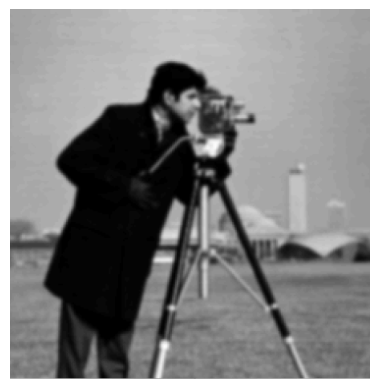

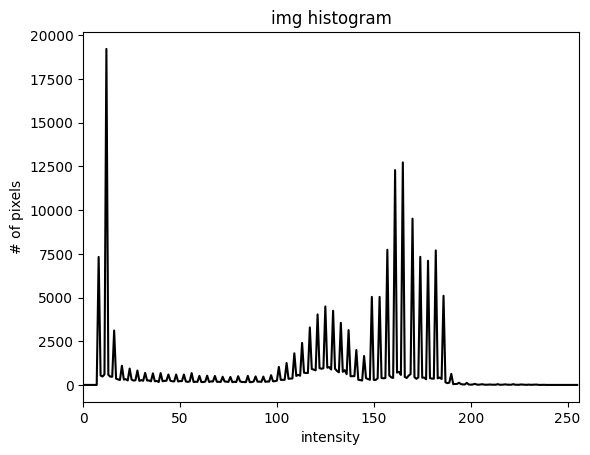

In [288]:
img = cv2.imread('in/camera_man_ruido.png', cv2.IMREAD_GRAYSCALE)

cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

# get histogram

hist = cv2.calcHist([img],[0],None,[256],[0,256])

plt.title('img histogram')
plt.xlabel('intensity')
plt.ylabel('# of pixels')
plt.xlim([0, 256])
plt.plot(hist, color='k')
# plt.hist(grayscale_img.ravel(), 256, [0, 256])
plt.show()

### Utils

In [289]:
# helps visualizing the image with opencv.showimg

def norm_og_img(img, og_img):
    norm = cv2.normalize(img, None, np.min(og_img), np.max(og_img), cv2.NORM_MINMAX)
    return np.round(norm).astype(np.uint8)

### Fourier stuff

In [290]:
# opencv: https://docs.opencv.org/4.x/de/dbc/tutorial_py_fourier_transform.html

def fft_cv2(img):
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    fshift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
    return magnitude_spectrum, fshift

def ifft_cv2(fft_img, fshift):
    M, N = fft_img.shape
    mask = np.ones((M, N, 2), np.uint8)

    fshift = fshift * mask
    
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    
    return img_back
    
def fft_np(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum, fshift

def ifft_np(fft_img, fshift):
    N, M = fft_img.shape
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)
    
    return img_back

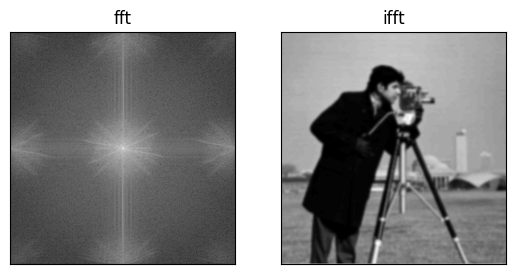

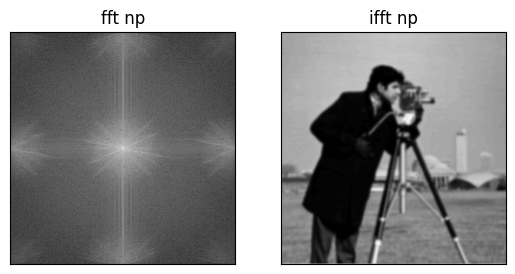

True

In [291]:
# test

# step 1: fft
fft_img, fshift = fft_cv2(img)
ifft_img = ifft_cv2(fft_img, fshift)

plt.subplot(121),plt.imshow(fft_img, cmap = 'gray')
plt.title('fft'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ifft_img, cmap = 'gray')
plt.title('ifft'), plt.xticks([]), plt.yticks([])
plt.show()

fft_img_norm = norm_og_img(fft_img, img)
ifft_img_norm = norm_og_img(ifft_img, img)

cv2.imwrite('out/misc/fft_img_cv2.png', fft_img_norm)
cv2.imwrite('out/misc/ifft_img_cv2.png', ifft_img_norm)

fft_img, fshift = fft_np(img)
ifft_img = ifft_np(fft_img, fshift)

plt.subplot(121),plt.imshow(fft_img, cmap = 'gray')
plt.title('fft np'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ifft_img, cmap = 'gray')
plt.title('ifft np'), plt.xticks([]), plt.yticks([])
plt.show()

fft_img_norm = norm_og_img(fft_img, img)
ifft_img_norm = norm_og_img(ifft_img, img)

cv2.imwrite('out/misc/fft_img_np.png', fft_img_norm)
cv2.imwrite('out/misc/ifft_img_np.png', ifft_img_norm)

### A. Eliminación de Ruido


Aplicar mínimo 3 filtros y máximo 6 filtros, ya sea de convolución, morfológicos o de Fourier para eliminar el ruido de la imagen, de manera que el rostro de la persona aparezca lo más nítido posible.

Fourier Utils

In [292]:
# from Digital Image Processing, Gonzalez, Woods, 4th edition, p. 284

# butteworth high pass filter
def high_pass_butterworth(img, D0, n):
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            H[u, v] = 1 / (1 + (D0 / D)**(2*n))
    return H

# butteworth low pass filter
def low_pass_butterworth(img, D0, n):
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            H[u, v] = 1 / (1 + (D / D0)**(2*n))
    return H

Tests

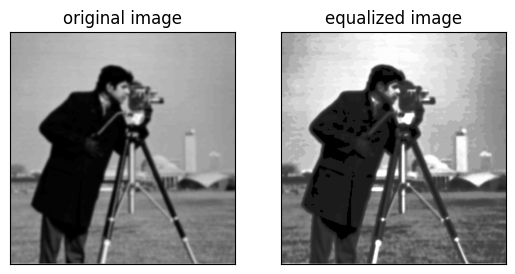

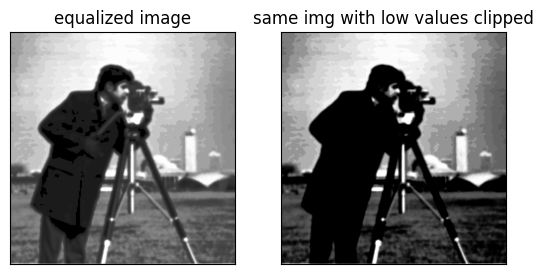

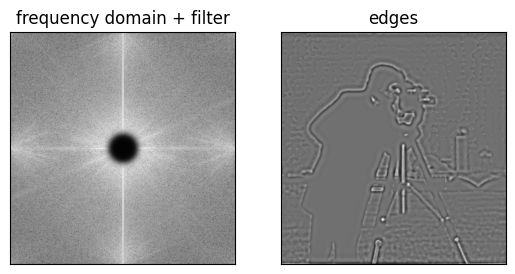

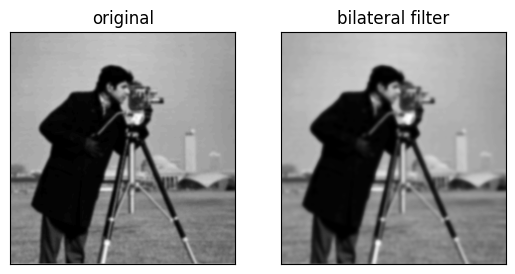

True

In [293]:
#test 0

# step 1: "sharpen" image with histogram equalization

equ = cv2.equalizeHist(img)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('original image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(equ, cmap = 'gray')
plt.title('equalized image'), plt.xticks([]), plt.yticks([])
plt.show()

img_c = np.clip(equ, 70, 255)

plt.subplot(121),plt.imshow(equ, cmap = 'gray')
plt.title('equalized image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_c, cmap = 'gray')
plt.title('same img with low values clipped'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test0/equ_img.png', img_c)

# step 2: butterworth high pass filter

fft_img, fshift = fft_np(img_c)

HPF = high_pass_butterworth(fft_img, 30, 4)

G_shift = fshift * HPF
G_shift_img = fft_img * HPF

edges = ifft_np(fshift, G_shift)

plt.subplot(121),plt.imshow(G_shift_img, cmap = 'gray')
plt.title('frequency domain + filter'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('edges'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test0/edges_v0.png', edges)

# step 3: bilateral filter

noise_reduction = cv2.bilateralFilter(img, 9, 75, 75)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('original'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noise_reduction, cmap = 'gray')
plt.title('bilateral filter'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test0/no_edge_v0.png', noise_reduction)

# step 4: combine

new_img_v0 = noise_reduction + edges

# step 5: blur to ease the edges

new_img_v0 = cv2.blur(new_img_v0, (3, 3))

cv2.imwrite('out/a/test0/a_v0.png', new_img_v0)

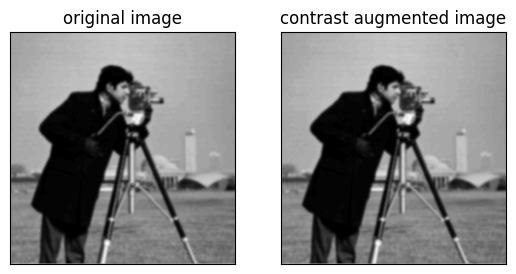

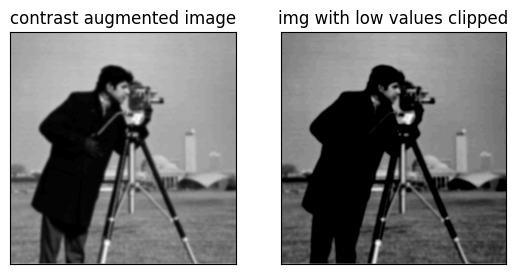

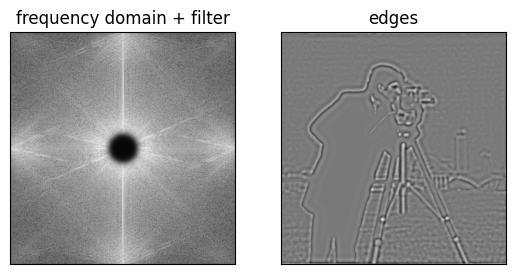

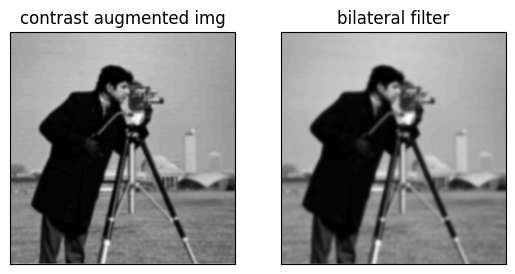

True

In [294]:
#test 1

# step 1: "sharpen" image with contrast

contrast_img = cv2.convertScaleAbs(img, 30, 1)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('original image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(contrast_img, cmap = 'gray')
plt.title('contrast augmented image'), plt.xticks([]), plt.yticks([])
plt.show()

img_c = np.clip(contrast_img, 70, 255)

plt.subplot(121),plt.imshow(contrast_img, cmap = 'gray')
plt.title('contrast augmented image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_c, cmap = 'gray')
plt.title('img with low values clipped'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test1/contrast_img.png', img_c)

# step 2: butterworth high pass filter

fft_img, fshift = fft_np(img_c)

HPF = high_pass_butterworth(fft_img, 30, 4)

G_shift = fshift * HPF
G_shift_img = fft_img * HPF

edges = ifft_np(fshift, G_shift)

plt.subplot(121),plt.imshow(G_shift_img, cmap = 'gray')
plt.title('frequency domain + filter'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('edges'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test1/edges_v1.png', edges)

# step 3: bilateral filter

noise_reduction = cv2.bilateralFilter(contrast_img, 9, 75, 75)

plt.subplot(121),plt.imshow(contrast_img, cmap = 'gray')
plt.title('contrast augmented img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noise_reduction, cmap = 'gray')
plt.title('bilateral filter'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test1/no_edge_v1.png', noise_reduction)

# step 4: combine

new_img_v1 = noise_reduction + edges

# step 5: blur to ease the edges

new_img_v1 = cv2.blur(new_img_v1, (3, 3))

cv2.imwrite('out/a/test1/a_v1.png', new_img_v1)

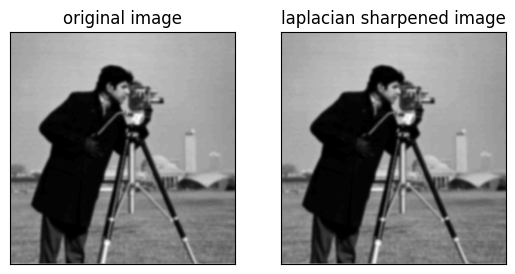

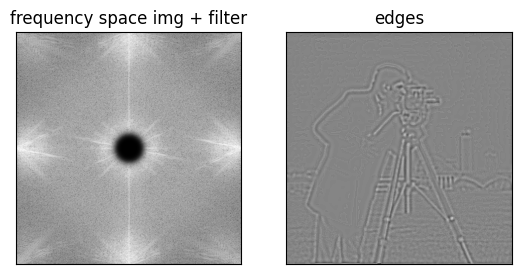

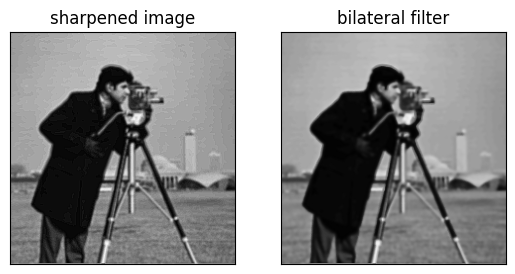

True

In [295]:
#test 2

# step 1: "sharpen" image with laplacian sharpen kernel

laplace_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

sharper_img = cv2.filter2D(img, -1, laplace_kernel)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('original image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(contrast_img, cmap = 'gray')
plt.title('laplacian sharpened image'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test2/sharper_img.png', sharper_img)

# step 2: butterworth high pass filter

fft_img, fshift = fft_np(sharper_img)

HPF = high_pass_butterworth(fft_img, 30, 4)

G_shift = fshift * HPF
G_shift_img = fft_img * HPF

edges = ifft_np(fshift, G_shift)

plt.subplot(121),plt.imshow(G_shift_img, cmap = 'gray')
plt.title('frequency space img + filter'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('edges'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test2/edges_v2.png', edges)

# step 3: bilateral filter

noise_reduction = cv2.bilateralFilter(sharper_img, 9, 75, 75)

plt.subplot(121),plt.imshow(sharper_img, cmap = 'gray')
plt.title('sharpened image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noise_reduction, cmap = 'gray')
plt.title('bilateral filter'), plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('out/a/test2/no_edge_v2.png', noise_reduction)

# step 4: combine

new_img_v2 = noise_reduction + edges

# step 5: blur to ease the edges

new_img_v2 = cv2.blur(new_img_v2, (3, 3))

cv2.imwrite('out/a/test2/a_v2.png', new_img_v2)

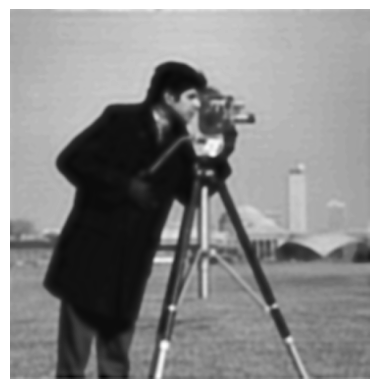

True

In [296]:
img_a = new_img_v1

plt.imshow(img_a, cmap = 'gray')
plt.axis('off')
plt.show()

cv2.imwrite('out/a/a.png', img_a)

### C. Rotar

Rotar la imagen de manera que la silueta de la persona aparezca completamente en vertical.

NOTA: Se invierte el paso B y el C por que el recorte se simplifica si se hace primero la rotación

In [297]:
# source: https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html

display_img_a = norm_og_img(img_a, img)

cv2.imshow('image',display_img_a)
cv2.waitKey(0)
cv2.destroyAllWindows()

N, M = img_a.shape

for angle in range(0, 45, 1):
    rotation_M = cv2.getRotationMatrix2D((M/2, N/2), angle, 1)
    rotated_img = cv2.warpAffine(img_a, rotation_M, (N, M))
    cv2.imwrite(f'out/c/tests/{angle}.png', rotated_img)


# trough observation, the best angle is 19 degrees
    
rotation_M = cv2.getRotationMatrix2D((M/2, N/2), 19, 1)
rotated_img = cv2.warpAffine(img_a, rotation_M, (N, M))

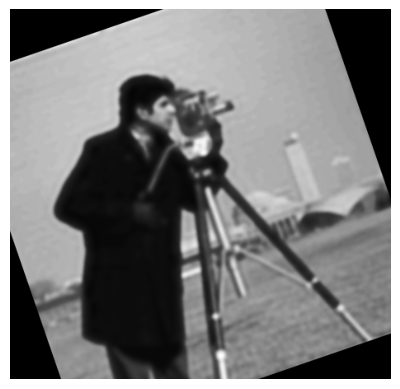

True

In [298]:
img_c = rotated_img

plt.imshow(img_c, cmap = 'gray')
plt.axis('off')
plt.show()

cv2.imwrite(f'out/c/c.png', img_c)

### B. Recortar Imagen

Recortar la imagen de manera que sólo aparezca la silueta de la persona en la misma, es decir, lo más ceñido posible a ella

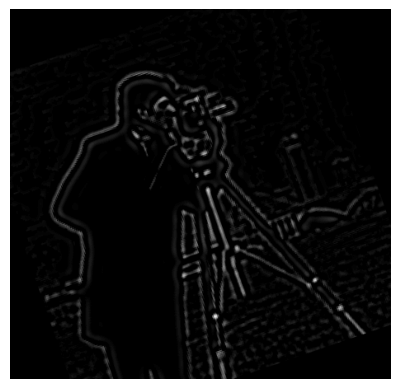

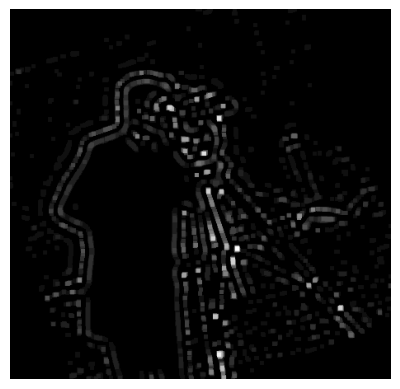

In [299]:
# idea 1: use the edges to find the crop offset automatically

# step 1: work with the edges calculated in part a.

edges = cv2.imread('out/a/test1/edges_v1.png', cv2.IMREAD_GRAYSCALE)

# step 2: get rid of weird edge in border
# step 3: rotate the image accordingly

edges[:, 0:10] = 0
edges[:, -10:] = 0
edges[0:10, :] = 0
edges[-10:, :] = 0

N, M = edges.shape

rotation_M = cv2.getRotationMatrix2D((M/2, N/2), 19, 1)
edges = cv2.warpAffine(edges, rotation_M, (N, M))

plt.imshow(edges, cmap = 'gray')
plt.axis('off')
plt.show()

# step 4: opening filter to get rid of noise

edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

plt.imshow(edges, cmap = 'gray')
plt.axis('off')
plt.show()

# step 5: traverse image and search for local maxima

# maybe I'm overdoing it lol

In [300]:
# idea 2: just crop it manually

display_img_c = norm_og_img(img_c, img)

cv2.imshow('image', display_img_c)
cv2.waitKey(0)
cv2.destroyAllWindows()

N, M = img_c.shape

y0 = 75
y1 = N
x0 = 53
x1 = 220

cropped_img = img_c[y0:y1, x0:x1]

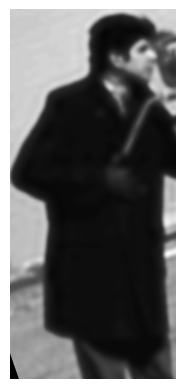

True

In [301]:
img_b = cropped_img

plt.imshow(img_b, cmap = 'gray')
plt.axis('off')
plt.show()

cv2.imwrite(f'out/b/b.png', img_b)

In [302]:
cv2.imwrite(f'out/final_img.png', img_b)

True